# DeFi Arbitrage Exploratory Analysis

Our hypothesis is that profitable intra-block arbitrage opportunities may exist between different DEX pools for the same asset pairs, due to mispricings arising from market inefficiencies. If such opportunities do exist, we could build a strategy which buys in one pool and sells in the other within the same block, realising a pure arbitrage profit with no inventory risk.

To investigate this hypothesis, we will compare pricing between the Uniswap V3 USDC-WETH 5bps pool (0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640) and the USDC-WETH 30bps pool (0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8). As these are both WETH-USDC pools, we expect prices to be tightly correlated. However, transaction costs (e.g. pool fees, gas costs, slippage, validator bribes) and market inefficiencies could cause price differences to emerge, especially during volatile periods. 

At this exploratory stage, we only want to determine whether there are any significant price differences between the pools. If significant price differences do exist, we could pursue our hypothesis further by developing and backtesting a trading strategy, taking account of transaction costs to determine whether an arbitrage could be profitably realised. 

To perform this analysis, we plot prices from both pools for a period of significant volatility (blocks 17937000-17937500), as well as the price difference between the pools.

In [ ]:
pip install polars matplotlib

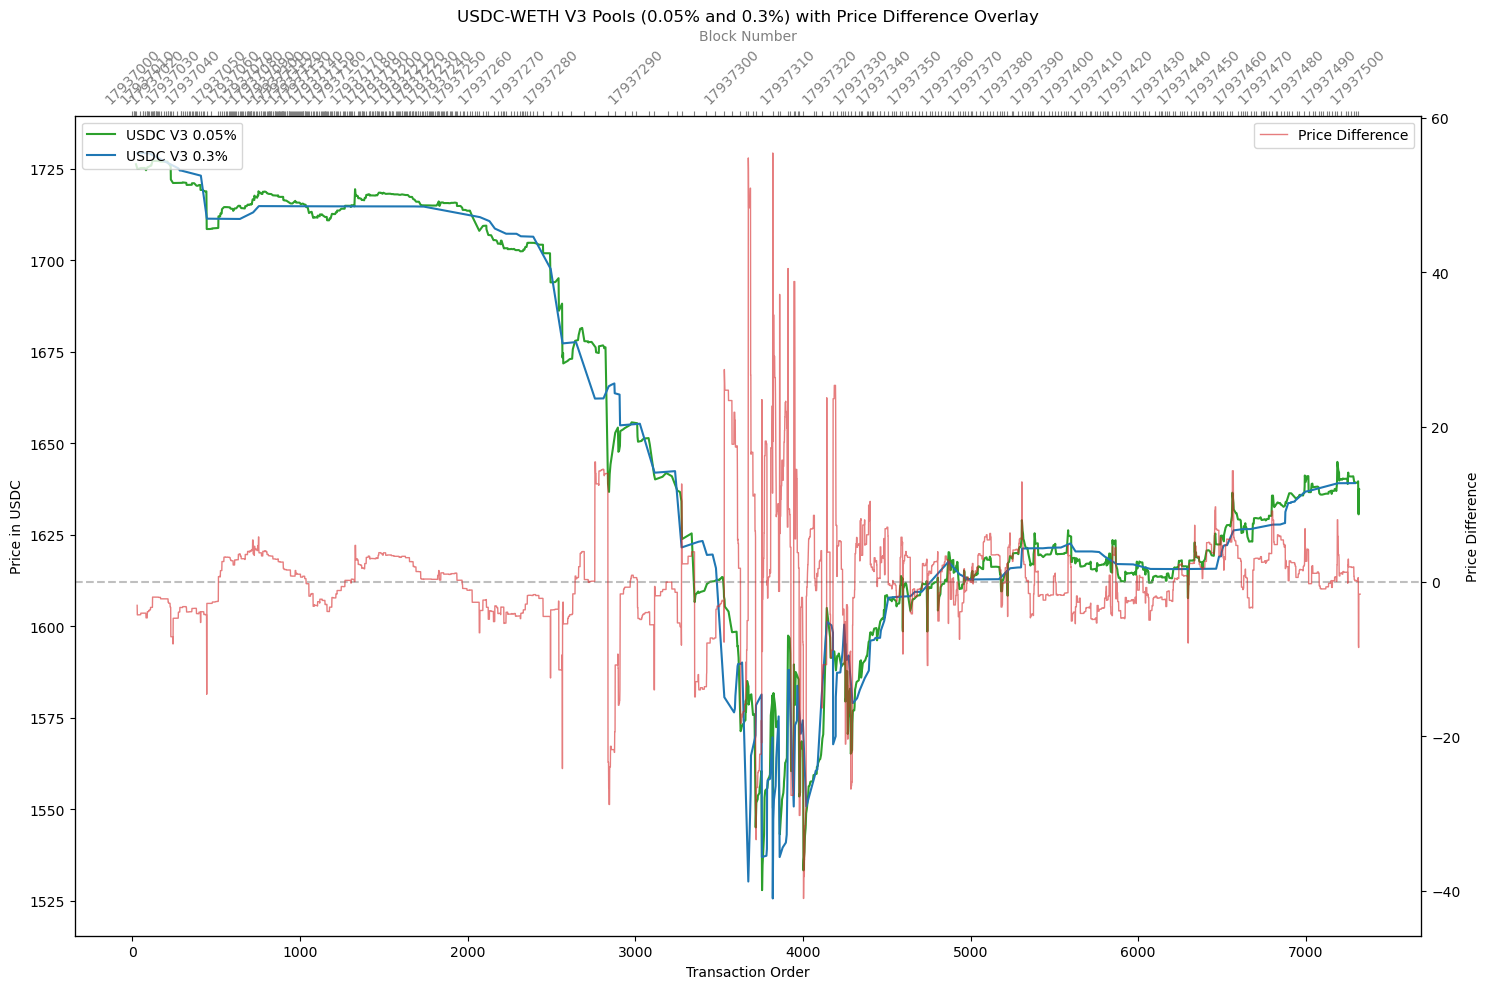

In [8]:
import polars as pl
import matplotlib.pyplot as plt

def load_datasets():
    return pl.scan_parquet('./data/prices_pool.parquet')

def limit_data_by_block(data, from_block, to_block):
    return data.filter((pl.col("block_number") >= from_block) & (pl.col("block_number") <= to_block))

def sort_data(data):
    return data.sort([pl.col('block_number'), pl.col('transaction_index')])

def calculate_price_differences(data):
    # Create conditional columns for each pool's price
    data = data.with_columns([
        pl.when(pl.col('pool_address') == '88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
        .then(pl.col('price'))
        .otherwise(pl.lit(None))
        .alias('last_known_price_005'),

        pl.when(pl.col('pool_address') == '8ad599c3a0ff1de082011efddc58f1908eb6e6d8')
        .then(pl.col('price'))
        .otherwise(pl.lit(None))
        .alias('last_known_price_03')
    ])

    # Apply forward_fill to fill the gaps
    data = data.with_columns([
        pl.col('last_known_price_005').forward_fill().alias('filled_last_known_price_005'),
        pl.col('last_known_price_03').forward_fill().alias('filled_last_known_price_03')
    ])

    # Calculate the price differences using with_columns
    data = data.with_columns([
        (pl.col('filled_last_known_price_005') - pl.col('filled_last_known_price_03')).alias('price_difference')
    ])


    return data

def plot_data(data, from_block, to_block):
    # Create a figure and axis object
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # Filter data for each pool address and plot
    pool_data_005 = data.filter(pl.col('pool_address') == '88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
    ax1.plot(pool_data_005['combined_order'].to_numpy(), pool_data_005['price'].to_numpy(), linestyle='-', color="#2ca02c", linewidth=1.5, label="USDC V3 0.05%")

    pool_data_03 = data.filter(pl.col('pool_address') == '8ad599c3a0ff1de082011efddc58f1908eb6e6d8')
    ax1.plot(pool_data_03['combined_order'].to_numpy(), pool_data_03['price'].to_numpy(), linestyle='-', color="#1f77b4", linewidth=1.5, label="USDC V3 0.3%")

    # Secondary y-axis for the price difference
    ax3 = ax1.twinx()
    ax3.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
    ax3.plot(data['combined_order'].to_numpy(), data['price_difference'].to_numpy(), color='#d62728', linewidth=1, linestyle='-', label='Price Difference', alpha=0.6)
    ax3.set_ylabel('Price Difference')
    ax3.tick_params(axis='y')
    ax3.legend(loc='upper right')

    # Secondary x-axis for block numbers
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())

    # Retrieve unique block numbers and create label blocks
    all_blocks = data['block_number'].unique().to_numpy()
    label_blocks = list(range(from_block, to_block + 1, 5))

    # Group by block_number and get the first combined_order for each block
    block_order_mapping_df = data.group_by('block_number').agg(pl.first('combined_order').alias('first_order'))

    # Convert the DataFrame to a dictionary with block numbers as keys and first_order as values
    block_order_dict = {row['block_number']: row['first_order'] for row in block_order_mapping_df.to_dicts()}

    # Retrieve unique block numbers and create label blocks
    all_blocks = data['block_number'].unique().to_list()
    label_blocks = list(range(from_block, to_block + 1, 10))

    # Setting x-ticks and x-tick labels
    ax2.set_xticks([block_order_dict.get(block, None) for block in all_blocks])
    ax2.set_xticklabels([str(block) if block in label_blocks and block in block_order_dict else "" for block in all_blocks], rotation=45)

    # Set labels, title, and grid for the primary y-axis
    ax1.set_xlabel('Transaction Order')
    ax1.set_ylabel('Price in USDC')
    ax1.legend(loc='upper left')

    # Set labels for the secondary x-axis
    ax2.set_xlabel('Block Number', color='gray')
    ax2.tick_params(axis='x', colors='gray')

    plt.title('USDC-WETH V3 Pools (0.05% and 0.3%) with Price Difference Overlay')
    plt.tight_layout()

    # Show the plot
    plt.show()

def main():
    from_block = 17937000
    to_block = 17937500

    data = load_datasets()
    limited_data = limit_data_by_block(data, from_block, to_block)
    combined_data_sorted = sort_data(limited_data)

    # Adjusted part for adding combined_order
    combined_data_sorted = combined_data_sorted.with_columns(
        [pl.arange(0, pl.count()).alias('combined_order')]
    )

    combined_data_sorted = calculate_price_differences(combined_data_sorted).collect()

    # print(combined_data_sorted.glimpse())
    plot_data(combined_data_sorted, from_block, to_block)

if __name__ == "__main__":
    main()

Our exploratory analysis shows that significant price differences (+/- ~$40) do indeed exist in some blocks. Whilst we cannot assume that a profitable arbitrage exists without factoring in transaction costs, this result gives us the confidence to invest time in the strategy building and backtesting stages. 